In [ ]:
################################################################################
######################      Lending Tree Loan Status      ######################
######################          Xgboost HPO GPU           ######################
######################            Upsampling              ######################
################################################################################

In [ ]:
!pip install eli5
!pip install lime
import os
import random
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
import joblib
from joblib import parallel_backend
from sklearn.model_selection import cross_val_score, KFold
from hyperopt import STATUS_OK
import xgboost as xgb
from xgboost import XGBClassifier
from hyperopt import hp
from hyperopt import tpe
from hyperopt import fmin, tpe, Trials
import csv
from datetime import datetime, timedelta
from timeit import default_timer as timer
import ast
import pickle
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import eli5 as eli
from eli5.sklearn import PermutationImportance 
from eli5 import show_weights
import webbrowser
from eli5.sklearn import explain_weights_sklearn
from eli5.formatters import format_as_dataframe, format_as_dataframes
from eli5 import show_prediction
import lime
from lime import lime_tabular

In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/LoanStatus/Data/

/content/drive/MyDrive/LoanStatus/Data


In [ ]:
# Set seed 
seed_value = 42
os.environ['LoanStatus_XgboostGPU_Upsampling'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)

In [ ]:
# Read data
trainDF = pd.read_csv("trainDF_US.csv", low_memory=False)
testDF  = pd.read_csv("testDF_US.csv", low_memory=False)

In [ ]:
X_train = trainDF.drop('loan_status', axis=1)
y_train = trainDF.loan_status
X_test =  testDF.drop('loan_status', axis=1)
y_test =  testDF.loan_status

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/Xgboost/trialOptions/

In [ ]:
################################################################################
###################### Xgboost GPU HPO for Upsampling Set ######################
############################## 100 Trials ######################################
################################################################################
# Define the number of trials
NUM_EVAL = 100

# Set same k-folds for reproducibility
kfolds = KFold(n_splits=5, shuffle=True, random_state=seed_value)

# Define parameter grid
xgb_tune_kwargs= {
    'n_estimators': hp.choice('n_estimators', np.arange(100, 500, dtype=int)),
    'max_depth': hp.choice('max_depth', np.arange(3, 10, dtype=int)),
    'subsample': hp.uniform('subsample', 0.25, 0.75),
    'gamma': hp.uniform('gamma', 0, 9),
    'learning_rate': hp.uniform('learning_rate', 0.0001, 0.3),
    'reg_alpha' : hp.choice('reg_alpha', np.arange(0, 30, dtype=int)),
    'reg_lambda' : hp.uniform('reg_lambda', 0, 3),
    'colsample_bytree' : hp.uniform('colsample_bytree', 0.5, 1),
    'colsample_bylevel' : hp.uniform('colsample_bylevel', 0.05, 0.5),  
    'min_child_weight' : hp.choice('min_child_weight', np.arange(0, 10, dtype=int)),
    }

# Define a function for optimization of hyperparameters
def my_xgb(config):
    """Xgboost HPO"""
    
    # Keep track of evaluations
    global ITERATION
    
    ITERATION += 1  
    
    # Parameters that are integers to remain integers
    config['n_estimators'] = int(config['n_estimators'])   
    
    # Start hyperopt at 3 for max_depth   
    config['max_depth'] = int(config['max_depth']) + 3
    
    # Define model type
    xgb = XGBClassifier(
        objective='binary:logistic',
        n_jobs=-1,
        random_state=seed_value,
        booster='gbtree', 
        tree_method='gpu_hist',  
        scale_pos_weight=1,
        use_label_encoder=False,
        verbosity=0,
        **config)
    
    # Start timer for each trial
    start = timer()
    
    # Perform k_folds cross validation to find lower error
    scores = -cross_val_score(xgb, X_train, y_train,
                                      scoring='roc_auc',
                                      cv=kfolds)
    run_time = timer() - start
    # Extract the best score
    best_score = np.max(scores)
    
    # Loss must be minimized
    loss = 1 - best_score

    # Write to the csv file ('a' means append)
    of_connection = open(out_file, 'a')
    writer = csv.writer(of_connection)
    writer.writerow([loss, config, ITERATION, run_time])
    
    return {'loss': loss, 'params': config, 'iteration': ITERATION, 
            'train_time': run_time, 'status': STATUS_OK}    

# Optimization algorithm
tpe_algorithm = tpe.suggest

# File to save first results
out_file = 'Xgboost_HPO_Upsampling_100_GPU_5fold.csv'
of_connection = open(out_file, 'w')
writer = csv.writer(of_connection)

# Write the headers to the file
writer.writerow(['loss', 'params', 'iteration', 'train_time'])
of_connection.close()

# Set global variable and HPO is run with fmin
global  ITERATION
ITERATION = 0
bayesOpt_Upsampling_trials = Trials()

In [ ]:
# Begin HPO trials for Upsampling data
# Start timer for experiment
start_time = datetime.now()
print("%-20s %s" % ("Start Time", start_time))

best_param = fmin(my_xgb, xgb_tune_kwargs, algo=tpe.suggest,
                  max_evals=NUM_EVAL, trials=bayesOpt_Upsampling_trials,
                  rstate= np.random.RandomState(42))

# End timer for experiment
end_time = datetime.now()
print("%-20s %s" % ("Start Time", start_time))
print("%-20s %s" % ("End Time", end_time))
print(str(timedelta(seconds=(end_time-start_time).seconds)))

Start Time           2022-02-11 20:47:38.509531
100%|██████████| 100/100 [5:24:55<00:00, 194.95s/it, best loss: 1.9343710108182373]
Start Time           2022-02-11 20:47:38.509531
End Time             2022-02-12 02:12:33.686933
5:24:55


In [ ]:
# Sort the trials with lowest loss (highest AUC) 
bayesOpt_Upsampling_trials_results = sorted(bayesOpt_Upsampling_trials.results, 
                                            key = lambda x: x['loss'])
print('Upsampling HPO GPU 100 trials 5fold: Top two trials with the lowest loss (highest AUC)')
print(bayesOpt_Upsampling_trials_results[:2])

Upsampling HPO GPU 100 trials 5fold: Top two trials with the lowest loss (highest AUC)
[{'loss': 1.9343710108182373, 'params': {'colsample_bylevel': 0.058634405251831605, 'colsample_bytree': 0.5068689191757614, 'gamma': 7.391202360090186, 'learning_rate': 0.0010284233210005843, 'max_depth': 7, 'min_child_weight': 5, 'n_estimators': 309, 'reg_alpha': 26, 'reg_lambda': 1.7709301629879193, 'subsample': 0.30873146426206194}, 'iteration': 22, 'train_time': 181.94988403800016, 'status': 'ok'}, {'loss': 1.9587176334655172, 'params': {'colsample_bylevel': 0.10129290953922618, 'colsample_bytree': 0.5466585360117832, 'gamma': 7.259042843754013, 'learning_rate': 0.0010337194642798808, 'max_depth': 8, 'min_child_weight': 5, 'n_estimators': 206, 'reg_alpha': 18, 'reg_lambda': 0.6026190751579736, 'subsample': 0.3584614673395253}, 'iteration': 30, 'train_time': 157.47054124900023, 'status': 'ok'}]


In [ ]:
# Access results
results = pd.read_csv('Xgboost_HPO_Upsampling_100_GPU_5fold.csv')

# Sort with best scores on top and reset index for slicing
results.sort_values('loss', ascending = True, inplace = True)
results.reset_index(inplace = True, drop = True)

# Convert from a string to a dictionary for later use
ast.literal_eval(results.loc[0, 'params'])

# Evaluate Best Results
# Extract the ideal number hyperparameters
best_bayes_params = ast.literal_eval(results.loc[0, 'params']).copy()

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/Xgboost/Model_PKL/

In [ ]:
# Re-create the best model and train on the training data
best_bayes_Upsampling_model = xgb.XGBClassifier(objective='binary:logistic',
                                                booster='gbtree',
                                                tree_method='gpu_hist', 
                                                scale_pos_weight=1,
                                                use_label_encoder=False,
                                                verbosity=0,
                                                n_jobs=-1, 
                                                random_state = seed_value, 
                                                **best_bayes_params)

# Fit the model
best_bayes_Upsampling_model.fit(X_train, y_train)

# Save model
Pkl_Filename = 'Xgboost_HPO_Upsamplin_100_GPU_5fold.pkl'  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(best_bayes_Upsampling_model, file)

# =============================================================================
# # To load saved model
# model = joblib.load('Xgboost_HPO_Upsamplin_100_GPU_5fold.pkl')
# print(model)
# =============================================================================

In [ ]:
print('\nModel Metrics for Xgboost HPO Upsampling 100trials GPU 5fold')
y_train_pred = best_bayes_Upsampling_model.predict(X_train)
y_test_pred = best_bayes_Upsampling_model.predict(X_test)

# Predict based on training 
y_pred_Upsampling_HPO = best_bayes_Upsampling_model.predict(X_test)

print('Results from Xgboost HPO 100 GPU 5fold on Upsampling Data:')
print('\n')
print('Classification Report:')
clf_rpt = classification_report(y_test, y_pred_Upsampling_HPO)
print(clf_rpt)
print('\n')
print('Confusion matrix:')
print(confusion_matrix(y_test, y_pred_Upsampling_HPO))
print('\n')
print('Accuracy score : %.3f'%accuracy_score(y_test, y_pred_Upsampling_HPO))
print('Precision score : %.3f'%precision_score(y_test, y_pred_Upsampling_HPO))
print('Recall score : %.3f'%recall_score(y_test, y_pred_Upsampling_HPO))
print('F1 score : %.3f'%f1_score(y_test, y_pred_Upsampling_HPO))


Model Metrics for Xgboost HPO Upsampling 100trials GPU 5fold
Results from Xgboost HPO 100 GPU 5fold on Upsampling Data:


Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.91      0.94    377848
           1       0.58      0.84      0.69     54625

    accuracy                           0.90    432473
   macro avg       0.78      0.87      0.81    432473
weighted avg       0.92      0.90      0.91    432473



Confusion matrix:
[[344984  32864]
 [  8986  45639]]


Accuracy score : 0.903
Precision score : 0.581
Recall score : 0.835
F1 score : 0.686


In [ ]:
# Evaluate predictive probability on the testing data 
preds = best_bayes_Upsampling_model.predict_proba(X_test)[:, 1]

print('The best model from Upsampling Bayes 100 GPU 5fold trials optimization scores {:.5f} AUC ROC on the test set.'.format(roc_auc_score(y_test, preds)))
print('This was achieved after {} search iterations'.format(results.loc[0, 'iteration']))

The best model from Upsampling Bayes 100 GPU 5fold trials optimization scores 0.94153 AUC ROC on the test set.
This was achieved after 22 search iterations


In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/Xgboost/bayesParams/

In [ ]:
# Create a new dataframe for storing parameters
bayes_params = pd.DataFrame(columns = list(ast.literal_eval(results.loc[0, 'params']).keys()),
                            index = list(range(len(results))))

# Add the results with each parameter a different column
for i, params in enumerate(results['params']):
    bayes_params.loc[i, :] = list(ast.literal_eval(params).values())
    
bayes_params['loss'] = results['loss']
bayes_params['iteration'] = results['iteration']

# Save dataframes of parameters
bayes_params.to_csv('bayes_params_Xgboost_HPO_Upsampling_100_GPU_5fold.csv', 
                    index = False)

In [ ]:
# Convert data types for graphing
bayes_params['colsample_bylevel'] = bayes_params['colsample_bylevel'].astype('float64')
bayes_params['colsample_bytree'] = bayes_params['colsample_bytree'].astype('float64')
bayes_params['gamma'] = bayes_params['gamma'].astype('float64')
bayes_params['learning_rate'] = bayes_params['learning_rate'].astype('float64')
bayes_params['reg_alpha'] = bayes_params['reg_alpha'].astype('float64')
bayes_params['reg_lambda'] = bayes_params['reg_lambda'].astype('float64')
bayes_params['subsample'] = bayes_params['subsample'].astype('float64')

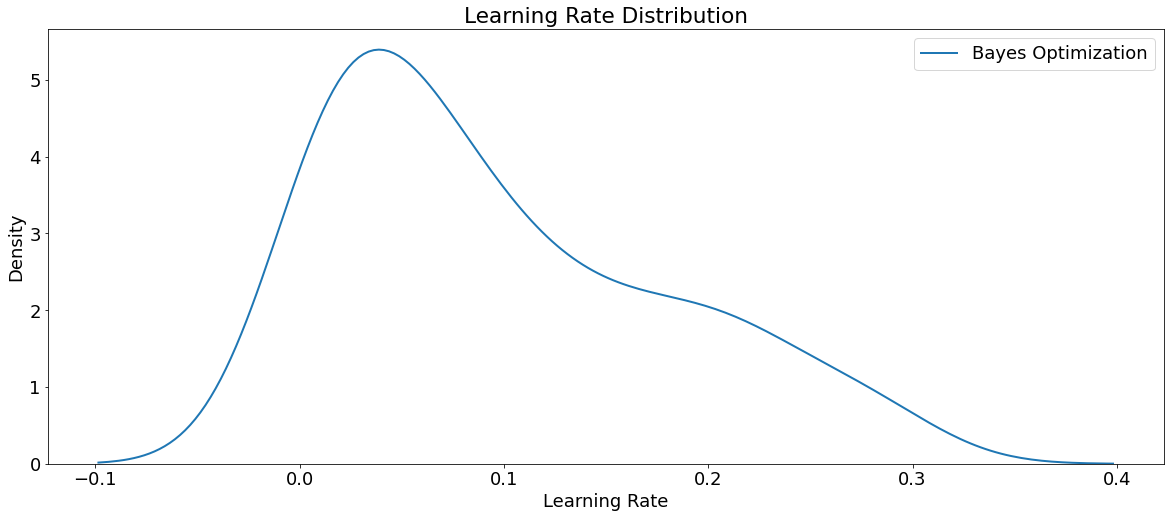

In [ ]:
# Density plots of the learning rate distributions 
plt.figure(figsize = (20, 8))
plt.rcParams['font.size'] = 18
sns.kdeplot(bayes_params['learning_rate'], label = 'Bayes Optimization', 
            linewidth = 2)
plt.legend(loc = 1)
plt.xlabel('Learning Rate'); plt.ylabel('Density'); plt.title('Learning Rate Distribution');
plt.show()


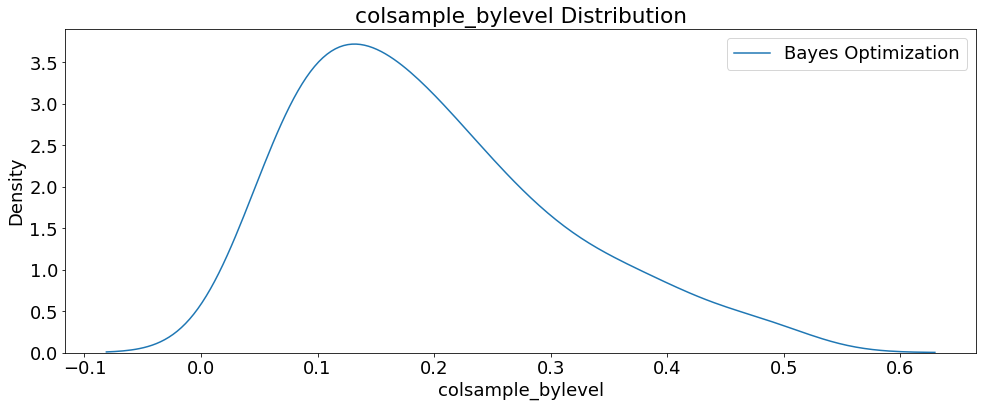

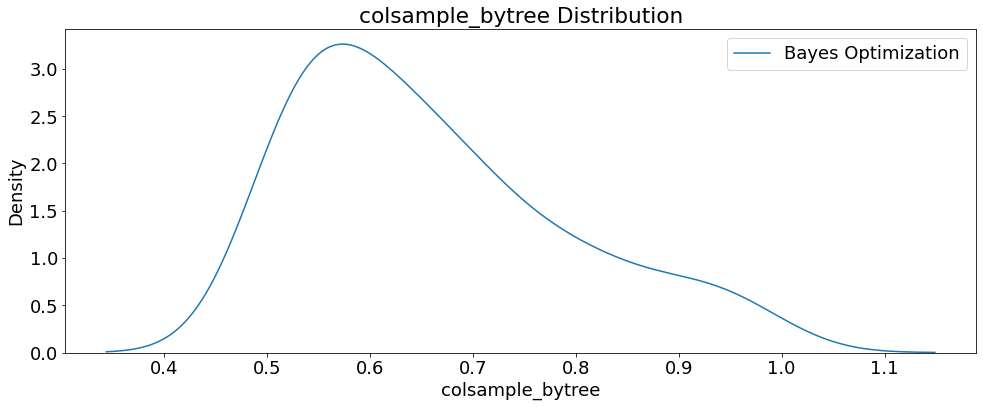

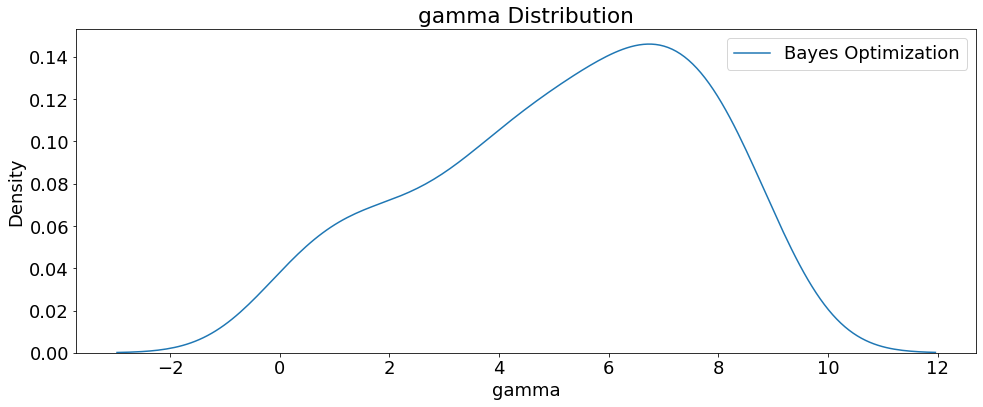

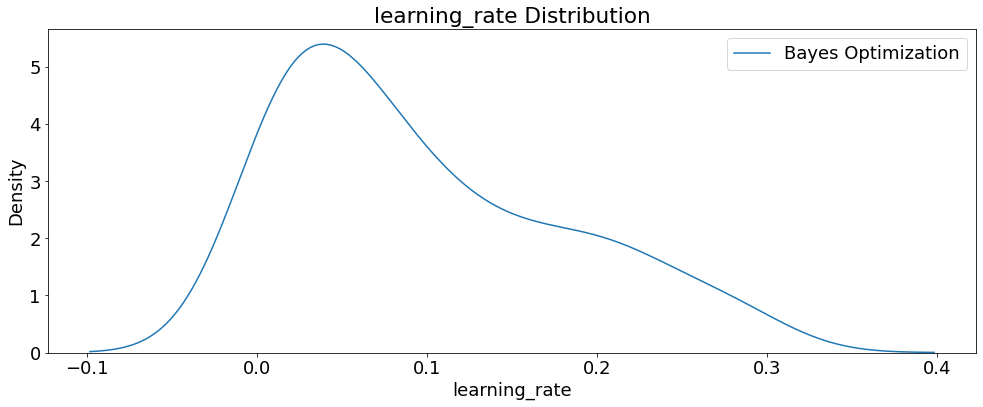

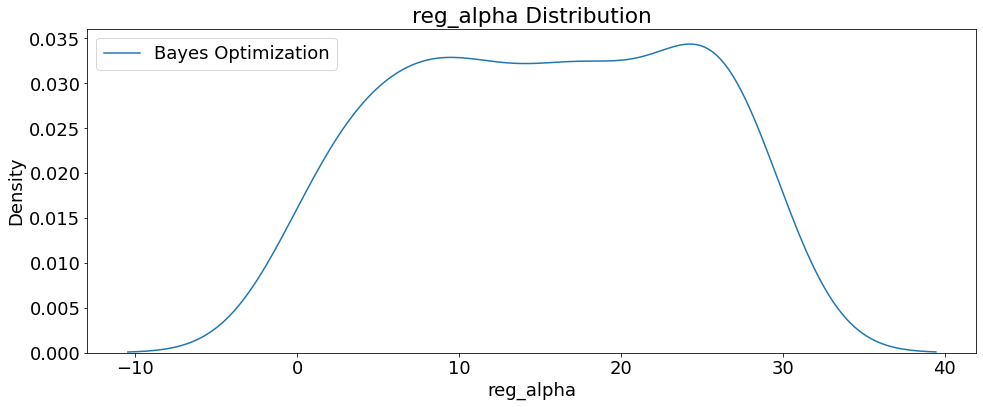

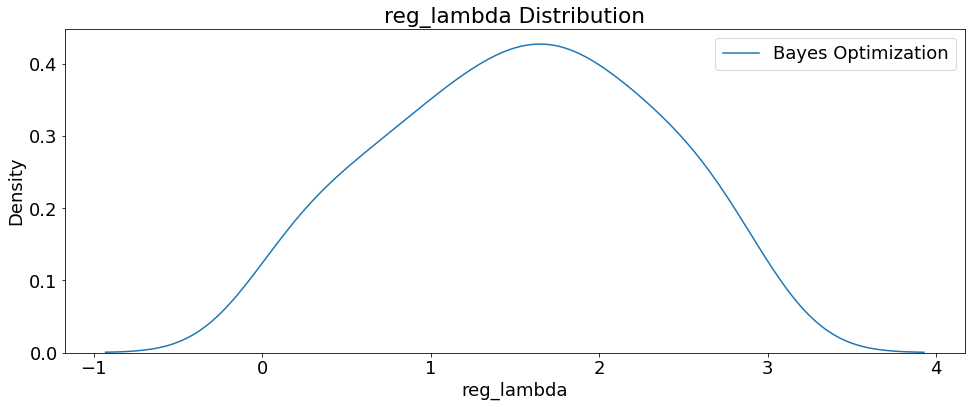

<Figure size 1008x432 with 0 Axes>

In [ ]:
# Create plots of Hyperparameters that are numeric 
for i, hpo in enumerate(bayes_params.columns):
    if hpo not in ['iteration', 'subsample', 'force_col_wise',
                     'max_depth', 'min_child_weight', 'n_estimators']:
        plt.figure(figsize = (14, 6))
        # Plot the random search distribution and the bayes search distribution
        if hpo != 'loss':
            sns.kdeplot(bayes_params[hpo], label = 'Bayes Optimization')
            plt.legend(loc = 0)
            plt.title('{} Distribution'.format(hpo))
            plt.xlabel('{}'.format(hpo)); plt.ylabel('Density')
            plt.tight_layout()
            plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

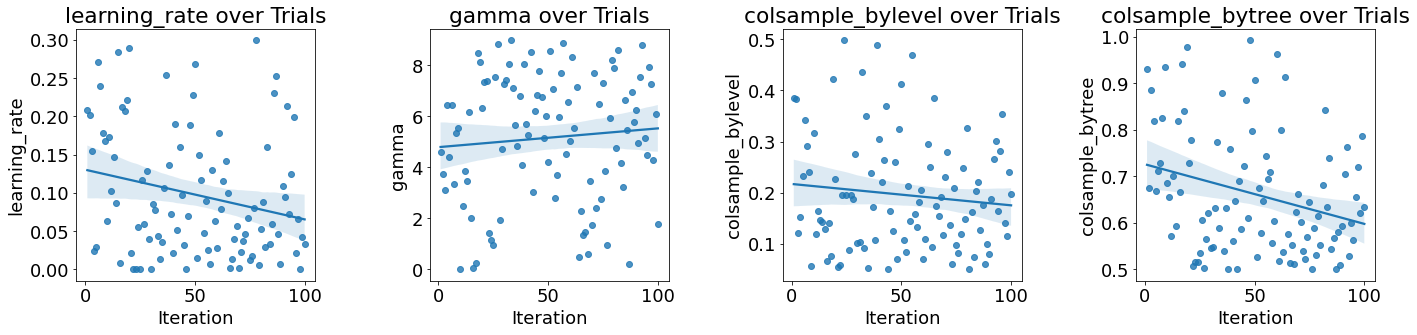

In [ ]:
# Plot quantitive hyperparameters
fig, axs = plt.subplots(1, 4, figsize = (20, 5))
i = 0
for i, hpo in enumerate(['learning_rate', 'gamma', 'colsample_bylevel',
                         'colsample_bytree']):
        # Scatterplot
        sns.regplot('iteration', hpo, data = bayes_params, ax = axs[i])
        axs[i].set(xlabel = 'Iteration', ylabel = '{}'.format(hpo), 
                   title = '{} over Trials'.format(hpo))
plt.tight_layout()
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


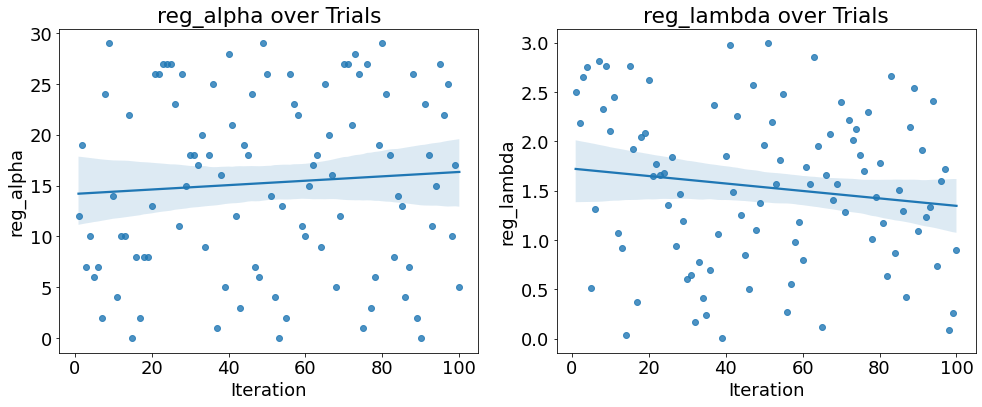

In [ ]:
# Scatterplot of regularization hyperparameters
fig, axs = plt.subplots(1, 2, figsize = (14, 6))
i = 0
for i, hpo in enumerate(['reg_alpha', 'reg_lambda']):
        sns.regplot('iteration', hpo, data = bayes_params, ax = axs[i])
        axs[i].set(xlabel = 'Iteration', ylabel = '{}'.format(hpo), 
                   title = '{} over Trials'.format(hpo))
plt.tight_layout()
plt.show()

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/Xgboost/Model_Explanations/

In [ ]:
# Model metrics with Eli5
# Compute permutation feature importance
perm_importance = PermutationImportance(best_bayes_Upsampling_model,
                                        random_state=seed_value).fit(X_test,
                                                                     y_test)

# Store feature weights in an object
html_obj = eli.show_weights(perm_importance,
                            feature_names = X_test.columns.tolist())

# Write feature weights html object to a file 
with open(r'/content/drive/MyDrive/LoanStatus/ML/Xgboost/Model_Explanations/best_bayes_Upsampling_100_GPU_5fold_WeightsFeatures.htm',
          'wb') as f:
    f.write(html_obj.data.encode("UTF-8"))

# Open the stored feature weights HTML file
url = r'/content/drive/MyDrive/LoanStatus/ML/Xgboost/Model_Explanations/best_bayes_Upsampling_100_GPU_5fold_WeightsFeatures.htm'
webbrowser.open(url, new=2)

html_obj

Weight,Feature
0.0731 ± 0.0005,last_pymnt_amnt
0.0701 ± 0.0006,out_prncp
0.0501 ± 0.0004,recoveries
0.0065 ± 0.0002,total_pymnt
0.0021 ± 0.0001,loan_amnt
0.0013 ± 0.0001,total_rec_late_fee
0.0011 ± 0.0001,installment
0.0007 ± 0.0002,num_bc_tl
0.0003 ± 0.0001,application_type_Joint App
0.0002 ± 0.0001,delinq_2yrs


In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/Xgboost/bestBayes_WeightsExplain/

In [ ]:
# Explain weights
explanation = eli.explain_weights_sklearn(perm_importance,
                            feature_names = X_test.columns.tolist())
exp = format_as_dataframe(explanation)

# Write processed data to csv
exp.to_csv('best_bayes_Upsampling_100_GPU_5fold_WeightsExplain.csv',
           index=False, encoding='utf-8-sig')